In [4]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import differential_evolution   
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
import pandas as pd
import math 
from datetime import date
from scipy.integrate import solve_ivp
import sys
import os
import copy 
#!pip install lifelines
import seaborn as sns
import statistics
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats

In [5]:
# Reading data
df = pd.read_csv("Tumor_lengths.csv")
df = df.loc[~df['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # remove patients with too few data points
df_anyue = pd.read_excel("Individual parameters_START_TKI patients_AYin.xlsx")
df_anyue = df_anyue[["PID","PD_Kg(/day)","PD_Kd(/day)","PD_Km(/day)"]]
df_anyue = df_anyue.rename(columns={"PID": "ID", "PD_Kg(/day)": "kg", "PD_Kd(/day)": "kd", "PD_Km(/day)": "km"})
df_anyue = df_anyue.loc[~df_anyue['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # remove patients with too few data points
cols = df_anyue.columns.tolist()
cols[2],cols[3]=cols[3],cols[2] # swap kd and km so anyue's columns match ours
df_anyue = df_anyue[cols]

In [6]:
# Logistic population model
def system_ode_logistic(time, populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    kd = params[2] #death rate due to medication

    days = time

    dSpop_dt = Spop * (r * (1- (Spop + Rpop)/kmax) - kd)
    dRpop_dt = Rpop * (r * (1- (Spop + Rpop)/kmax))
    return [dSpop_dt, dRpop_dt]

# Cost function
def cost_func_logistic(params, time, data):
    # initial_populations = params[3:]
    initial_populations = [params[3], data[0]-params[3]]
    tspan = [days[0], days[-1]]
    
    pred_data_log = solve_ivp(system_ode_logistic, tspan, initial_populations, 
                             t_eval = np.ravel(days), args = tuple([params[:3]]))
    
    if pred_data_log.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data_log.y[0]
        rpop = pred_data_log.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        mean_abs_error = (np.sum(np.abs(sum_pops-data)))/len(data)
        #rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        #rmse = 1e30


    return msq_error


##### logistic with DE

In [7]:
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    max_value = max(data[0], data[-1])

    print("Working on patient:", id, " Number of data points:", len(days))
    #bounds = [(3e-2, 3e-1), (1.1*max_value, 2*max_value), (1e-2, 1e-1),(0, data[0]) # r, K, kd, spop, rpop
    bounds = [(1e-3, 3e-1), (1.1*max_value, 2*max_value), (1e-2, 1e-1),(0, data[0]-1e-3)] # r, K, kd, spop0, 

    # Use differential_evolution to perform a random search
    opt_result_log = differential_evolution(cost_func_logistic, bounds, args=(days, data))
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun]

Working on patient: A1002  Number of data points: 16
Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 6
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


In [8]:
df_log = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','kd','spop_0','mse'])
df_log

,r,Kmax,kd,spop_0,mse
A1002,0.023281,27596.138839,0.043542,13865.440830,1.213081e+06
A1004,0.001000,6591.208399,0.034898,5435.394980,8.404832e+01
A1006,0.001000,20714.252937,0.057540,17288.291783,3.057313e+04
A1007,0.001652,25081.316485,0.028270,8552.648828,3.193549e+05
A1008,0.001602,23533.512575,0.024351,10777.875690,8.295688e+04
A1009,0.012202,19994.268765,0.031256,16900.852494,3.970655e+05
A1011,0.001000,7776.681177,0.022711,3902.346886,2.011081e+03
A1012,0.001198,19774.735727,0.015662,11304.803957,2.236724e+06
A1013,0.001000,18927.971728,0.046640,15168.146036,5.297680e+04
A1014,0.005144,543.597449,0.030273,271.272544,2.418390e+02


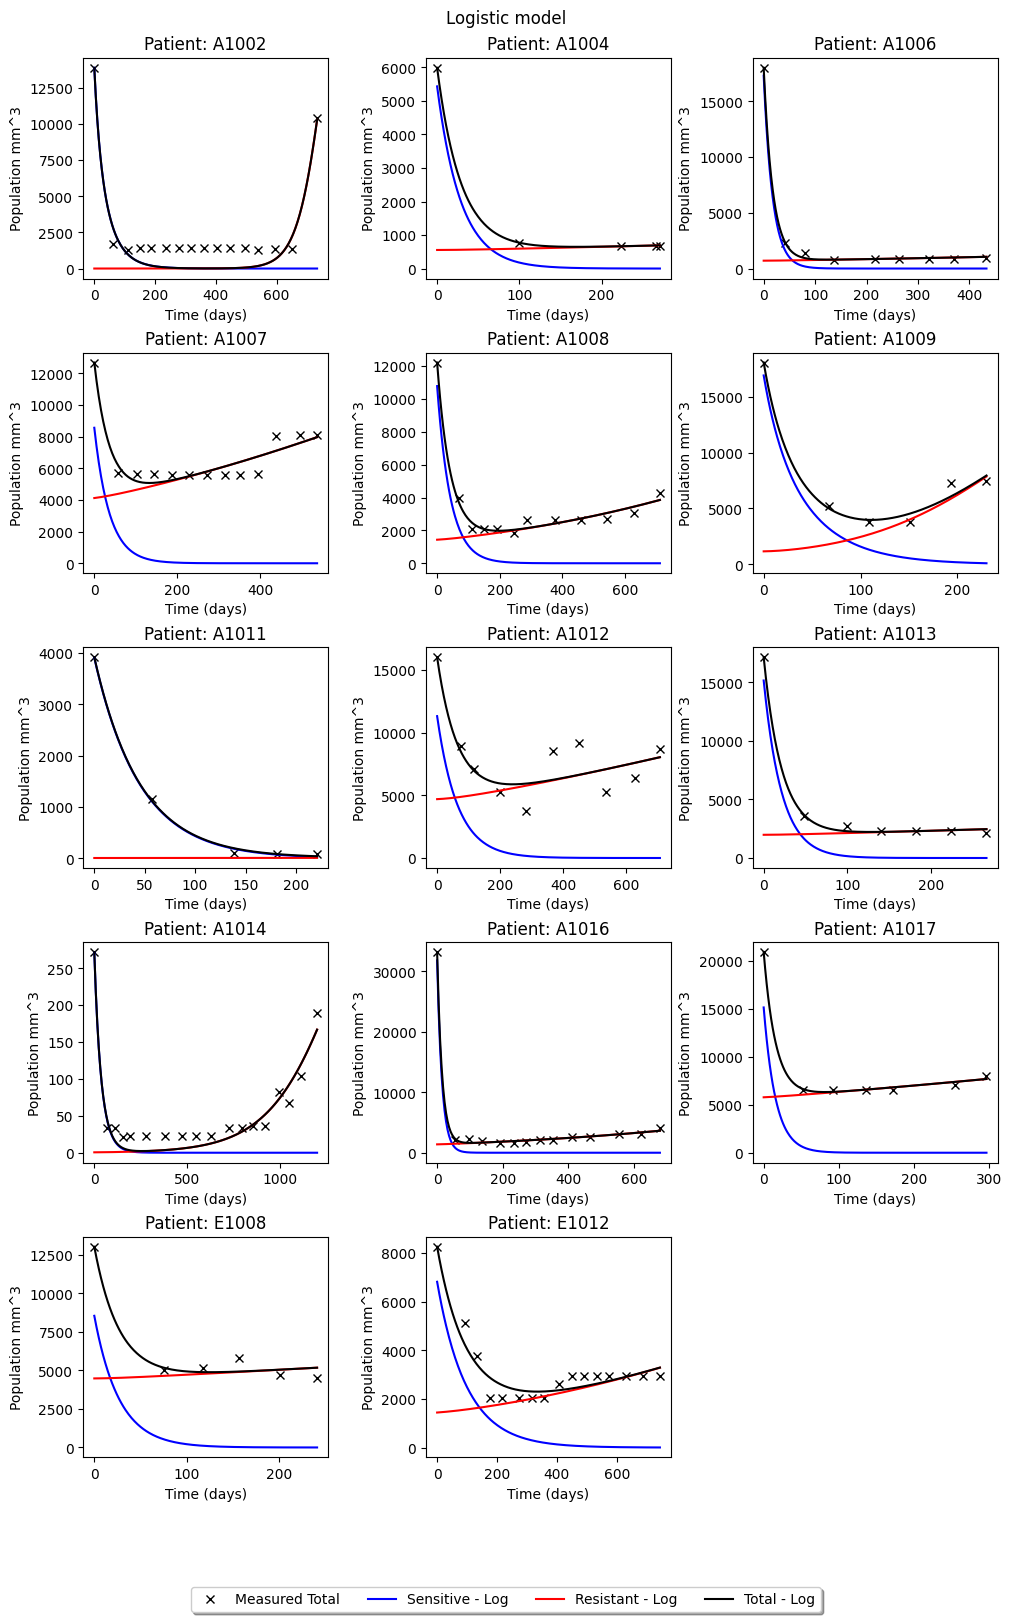

In [9]:
# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = master_dictionary[id]
    init_populations_log = [optimal_params_log[3], data[0]-optimal_params_log[3]]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model')  
plt.show()

##### Logistic DE MTD vs 1/2 MTD

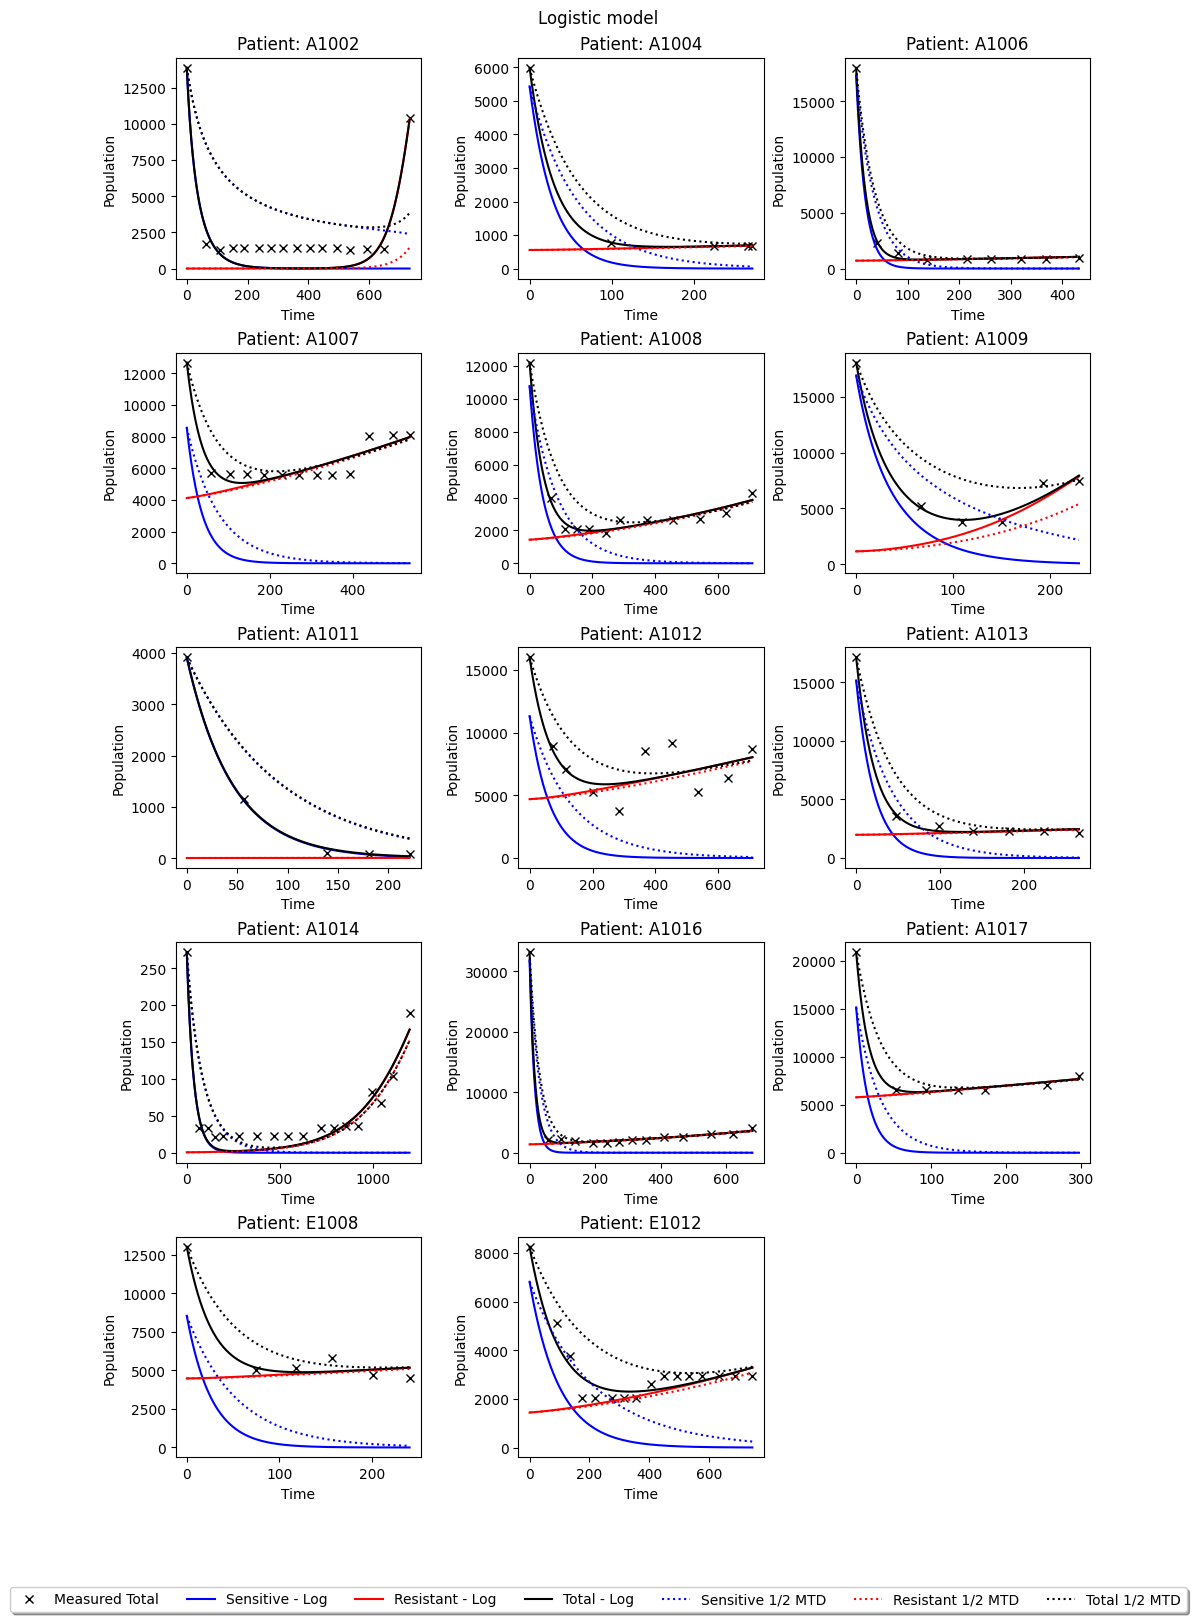

In [10]:
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = master_dictionary[id]
    init_populations_log = [optimal_params_log[3], data[0]-optimal_params_log[3]]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

# half dose
    optimal_params_half = master_dictionary_copy[id]
    init_populations_half = [optimal_params_half[3], data[0]-optimal_params_half[3]]

    pred_data_half = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_half, dense_output=True,
                            args = tuple([optimal_params_half[:3]]))
    sum_pops_half = np.sum(pred_data_half.sol(tspan), axis=0)



#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')

     # plot with half medication
    ax.plot(tspan, pred_data_half.sol(tspan)[0], 'b:', label='Sensitive 0.5*MTD') 
    ax.plot(tspan, pred_data_half.sol(tspan)[1], 'r:', label='Resistant 0.5*MTD') 
    ax.plot(tspan, sum_pops_half, 'k:', label='Total 0.5*MTD')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),
                    Line2D([0], [0], color='b', linestyle=':', label='Sensitive 1/2 MTD'),
                   Line2D([0], [0], color='r', linestyle=':', label='Resistant 1/2 MTD'),
                   Line2D([0], [0], color='k', linestyle= ':' ,label='Total 1/2 MTD'),
                   ]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model')  
plt.show()

##### Extending time MTD vs 1/2 MTD logistic

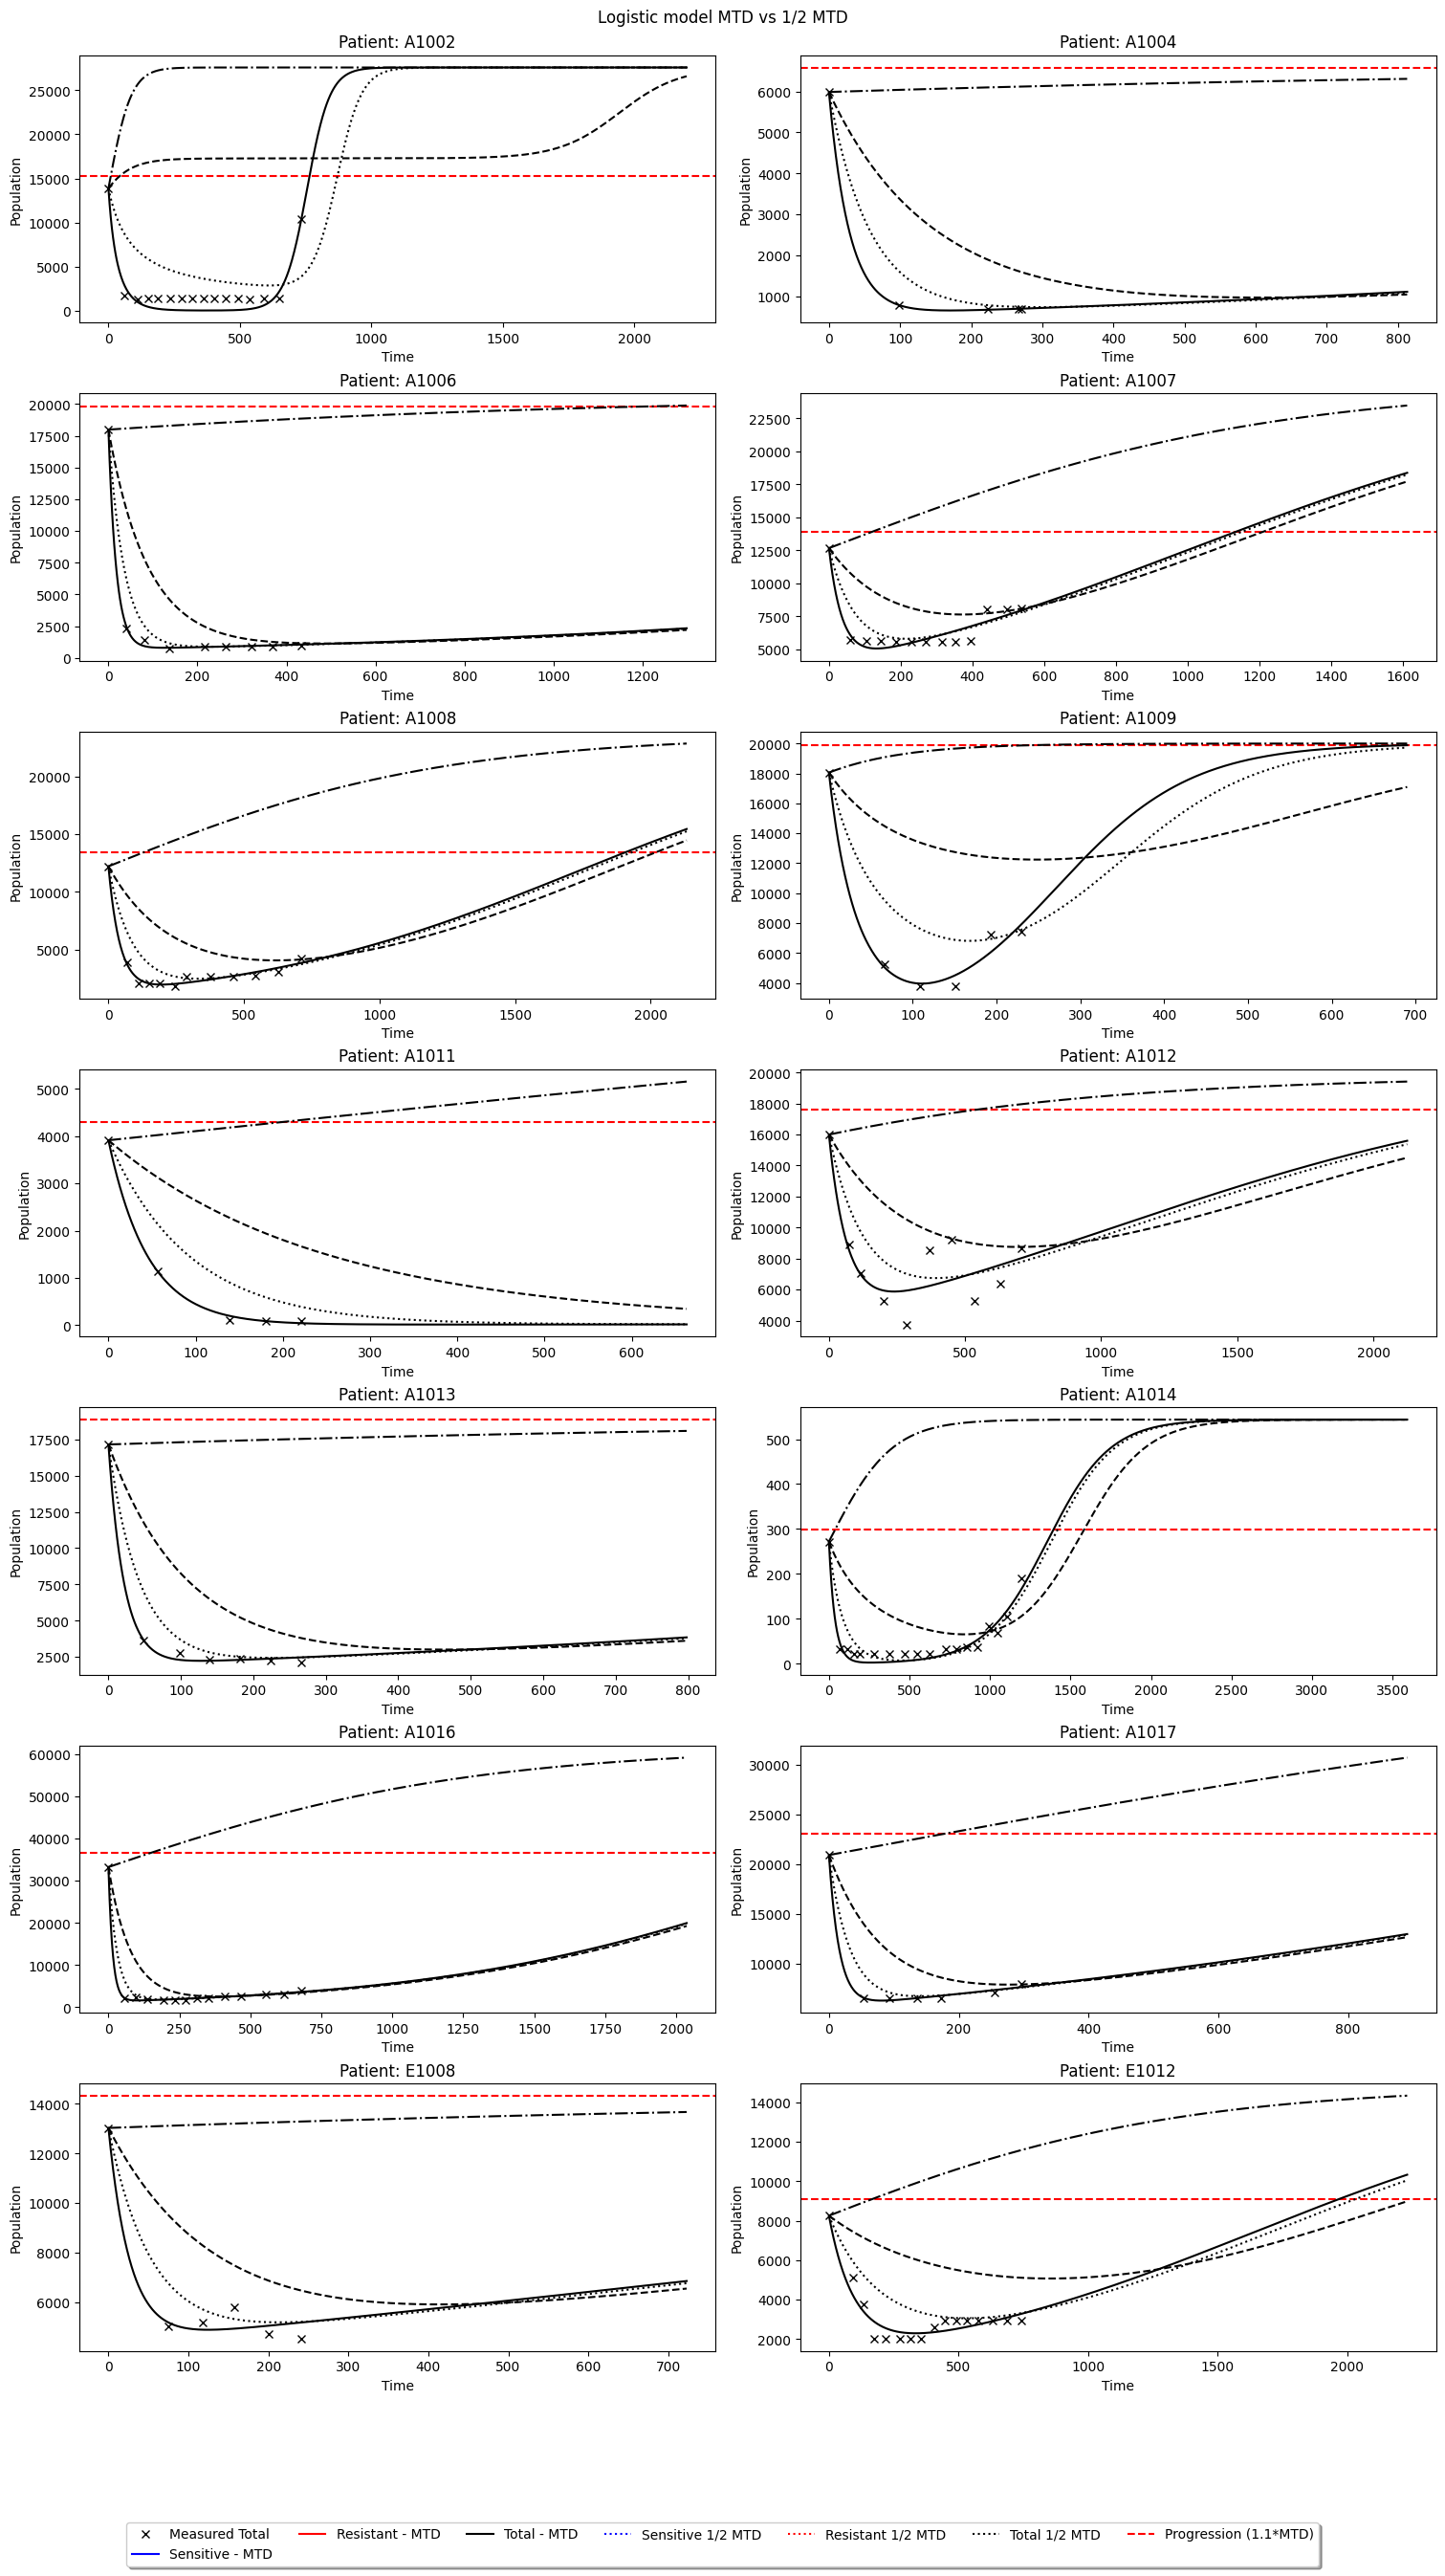

In [22]:
progression_list = []
progression_half_list = []
progression_02_list = []
progression_list_0 = []
comp_release_list = []
comp_release_half_list = []
comp_release_02_list = []
comp_release_list_0 = []

sim_time_factor = 3

# Store changed medication parameters
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

master_dictionary_copy2 = copy.deepcopy(master_dictionary) 
for key in master_dictionary_copy2:
    master_dictionary_copy2[key][2] *= 0.2 # simulate dose of 0.2 MTD

master_dictionary_copy0 = copy.deepcopy(master_dictionary) 
for key in master_dictionary_copy0:
    master_dictionary_copy0[key][2] *= 0 # simulate dose of 0

# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 25), constrained_layout=True)

# fitting data for parameters with 0, 0.2, 0.5, 1 * MTD
for index, id in enumerate(unique_IDs, start=0):
    
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()

    tspan = np.linspace(0, sim_time_factor*days[-1], 1000)

### optimal params MTD
    optimal_params_log = master_dictionary[id]
    init_populations_log = [optimal_params_log[3],data[0]-optimal_params_log[3]]
    pred_data_log = solve_ivp(system_ode_logistic, [0,sim_time_factor*days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

### optimal params + 0.5 MTD
    optimal_params_log_half = master_dictionary_copy[id] 
    init_populations_log_half = [optimal_params_log_half[3],data[0]-optimal_params_log_half[3]]

    pred_data_log_half = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_log_half, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_log_half[:3]]))
    sum_pops_log_half = np.sum(pred_data_log_half.sol(tspan), axis=0)

### optimal params + 0.2 medication
    optimal_params_2 = master_dictionary_copy2[id] 
    init_populations_2 = [optimal_params_2[3],data[0]-optimal_params_2[3]]
    pred_data_2 = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_2, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_2[:3]]))
    sum_pops_2 = np.sum(pred_data_2.sol(tspan), axis=0)

### optimal params + 0 medication
    optimal_params_0 = master_dictionary_copy0[id] 
    init_populations_0 = [optimal_params_0[3],data[0]-optimal_params_0[3]]
    pred_data_0 = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_0, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_0[:3]]))
    sum_pops_0 = np.sum(pred_data_0.sol(tspan), axis=0)


    # Find progression for logistic MTD
    progression_mtd = np.argmin(np.abs(sum_pops_log - 1.1*data[0]))
    x_value_progression = tspan[progression_mtd]

    # Find progression for logistic half MTD
    progression_half_mtd = np.argmin(np.abs(sum_pops_log_half - 1.1*data[0]))
    x_value_progression_half = tspan[progression_half_mtd]

    # Find progression for logistic 0.2 MTD
    progression_02_mtd = np.argmin(np.abs(sum_pops_2 - 1.1*data[0]))
    x_value_progression_02 = tspan[progression_02_mtd]

    # Find progression for logistic 0 MTD
    progression_0_mtd = np.argmin(np.abs(sum_pops_0 - 1.1*data[0]))
    x_value_progression_0 = tspan[progression_0_mtd]


    # Append the id and x_value_progression to the list
    progression_list.append((id, x_value_progression))
    progression_half_list.append((id, x_value_progression_half))
    progression_02_list.append((id, x_value_progression_02))
    progression_list_0.append((id, x_value_progression_0))
    


#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    ax.plot(days, data, 'kx', label='Measured Total') 
    ax.axhline(y=1.1*data[0], color='r', linestyle='--') ### line to show progression

    # plot with full medication
    #ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    #ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')

    # plot with half medication
    #ax.plot(tspan, pred_data_log_half.sol(tspan)[0], 'b:', label='Sensitive - Log') 
    #ax.plot(tspan, pred_data_log_half.sol(tspan)[1], 'r:', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log_half, 'k:', label='Total - Log')

    # plot with 0.2 medication
    #ax.plot(tspan, pred_data_2.sol(tspan)[0], 'b:', label='Sensitive - Log')
    #ax.plot(tspan, pred_data_2.sol(tspan)[1], 'r:', label='Resistant - Log')
    ax.plot(tspan, sum_pops_2, 'k--', label='Total - Log')

    # plot with 0 medication
    #ax.plot(tspan, pred_data_0.sol(tspan)[0], 'b:', label='Sensitive - Log')
    #ax.plot(tspan, pred_data_0.sol(tspan)[1], 'r:', label='Resistant - Log')
    ax.plot(tspan, sum_pops_0, 'k-.', label='Total - Log') 

    #set axis labels
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - MTD'),
                   Line2D([0], [0], color='r', label='Resistant - MTD'),
                   Line2D([0], [0], color='k',label='Total - MTD'),
                   Line2D([0], [0], color='b', linestyle=':', label='Sensitive 1/2 MTD'),
                   Line2D([0], [0], color='r', linestyle=':', label='Resistant 1/2 MTD'),
                   Line2D([0], [0], color='k', linestyle= ':' ,label='Total 1/2 MTD'),
                   Line2D([0], [0], color='r', linestyle='--', label='Progression (1.1*MTD)')]


fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model MTD vs 1/2 MTD')  
plt.show()

##### TTP & competitive release

In [23]:
# lists to store progression and competitive release times
progression_list = []
progression_half_list = []
progression_02_list = []
progression_list_0 = []
comp_release_list = []
comp_release_half_list = []
comp_release_02_list = []
comp_release_list_0 = []

sim_time_factor = 10 ### change this to extend time

# Store changed medication parameters
master_dictionary_copy = copy.deepcopy(master_dictionary) 
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5 # simulate dose of 0.5 MTD

master_dictionary_copy2 = copy.deepcopy(master_dictionary) 
for key in master_dictionary_copy2:
    master_dictionary_copy2[key][2] *= 0.2 # simulate dose of 0.2 MTD

master_dictionary_copy0 = copy.deepcopy(master_dictionary) 
for key in master_dictionary_copy0:
    master_dictionary_copy0[key][2] *= 0 # simulate dose of 0


for index, id in enumerate(unique_IDs, start=0):
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, sim_time_factor*days[-1], 1000)

### optimal params original medication 
    optimal_params_log = master_dictionary[id]
    init_populations_log = [optimal_params_log[3],data[0]-optimal_params_log[3]]
    pred_data_log = solve_ivp(system_ode_logistic, [0,sim_time_factor*days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

### optimal params 1/2 medication
    optimal_params_log_half = master_dictionary_copy[id] 
    init_populations_log_half = [optimal_params_log_half[3],data[0]-optimal_params_log_half[3]]

    pred_data_log_half = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_log_half, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_log_half[:3]]))
    sum_pops_log_half = np.sum(pred_data_log_half.sol(tspan), axis=0)

### optimal params 0.2 medication
    optimal_params_log_02 = master_dictionary_copy2[id] 
    init_populations_log_02 = [optimal_params_log_02[3],data[0]-optimal_params_log_02[3]]

    pred_data_log_02 = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_log_02, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_log_02[:3]]))
    sum_pops_log_02 = np.sum(pred_data_log_02.sol(tspan),    axis=0)

### optimal params 0 medication
    optimal_params_log_0 = master_dictionary_copy0[id]
    init_populations_log_0 = [optimal_params_log_0[3],data[0]-optimal_params_log_0[3]]

    pred_data_log_0 = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_log_0, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_log_0[:3]]))
    sum_pops_log_0 = np.sum(pred_data_log_0.sol(tspan), axis=0)
                                

# Find progression for logistic MTD
    progression_mtd = np.argmin(np.abs(sum_pops_log - 1.1*data[0]))
    x_value_progression = tspan[progression_mtd]
    progression_list.append(x_value_progression)

# Find progression for logistic half MTD
    progression_half_mtd = np.argmin(np.abs(sum_pops_log_half - 1.1*data[0]))
    x_value_progression_half = tspan[progression_half_mtd]
    progression_half_list.append(x_value_progression_half)

# Find progression for logistic 0.2 MTD
    progression_02_mtd = np.argmin(np.abs(sum_pops_log_02 - 1.1*data[0]))
    x_value_progression_02 = tspan[progression_02_mtd]
    progression_02_list.append(x_value_progression_02)

# Find progression for logistic 0 MTD
    progression_0_mtd = np.argmin(np.abs(sum_pops_log_0 - 1.1*data[0]))
    x_value_progression_0 = tspan[progression_0_mtd]
    progression_list_0.append(x_value_progression_0)


# find time to competitive release MTD
    comp_rel_mtd = np.argmin(np.abs(pred_data_log.sol(tspan)[0]-pred_data_log.sol(tspan)[1]))
    x_val_cr_mtd = tspan[comp_rel_mtd]
    comp_release_list.append(x_val_cr_mtd)

# find time to competitive release half MTD
    comp_rel_half = np.argmin(np.abs(pred_data_log_half.sol(tspan)[0]-pred_data_log_half.sol(tspan)[1]))
    x_val_cr_half = tspan[comp_rel_half]
    comp_release_half_list.append(x_val_cr_half)

# find time to competitive release 0.2 MTD
    comp_rel_02 = np.argmin(np.abs(pred_data_log_02.sol(tspan)[0]-pred_data_log_02.sol(tspan)[1]))
    x_val_cr_02 = tspan[comp_rel_02]
    comp_release_02_list.append(x_val_cr_02)

# find time to competitive release 0 MTD
    comp_rel_0 = np.argmin(np.abs(pred_data_log_0.sol(tspan)[0]-pred_data_log_0.sol(tspan)[1]))
    x_val_cr_0 = tspan[comp_rel_0]
    comp_release_list_0.append(x_val_cr_0)

    
# Combine lists into a DataFrame
df_all_progressions = pd.DataFrame({
    'id': unique_IDs,
    'progression': progression_list,
    'progression half MTD': progression_half_list,
    'progression 0.2 MTD' : progression_02_list,
    'progression 0 ' : progression_list_0,
    'competitive release': comp_release_list,
    'competitive release half MTD': comp_release_half_list,
    'competitive release 0.2 MTD' : comp_release_02_list,
    'competitive release 0 ' : comp_release_list_0
})

# adding event columns 
df_all_progressions['progression_event'] = df_all_progressions['progression'].apply(lambda x: 0 if x == 0 else 1)
df_all_progressions['progression_event_half'] = df_all_progressions['progression half MTD'].apply(lambda x: 0 if x == 0 else 1)
df_all_progressions['progression_event_02'] = df_all_progressions['progression 0.2 MTD'].apply(lambda x: 0 if x == 0 else 1)
df_all_progressions['progression_event_0'] = df_all_progressions['progression 0 '].apply(lambda x: 0 if x == 0 else 1)

df_all_progressions['cr_event'] = df_all_progressions['competitive release'].apply(lambda x: 0 if x == 0 else 1)
df_all_progressions['cr_event_half'] = df_all_progressions['competitive release half MTD'].apply(lambda x: 0 if x == 0 else 1)
df_all_progressions['cr_event_02_MTD'] = df_all_progressions['competitive release 0.2 MTD'].apply(lambda x: 0 if x == 0 else 1)
df_all_progressions['cr_event_0'] = df_all_progressions['competitive release 0 '].apply(lambda x: 0 if x == 0 else 1)

# Print the DataFrame
df_all_progressions

,id,progression,progression half MTD,progression 0.2 MTD,progression 0,competitive release,competitive release half MTD,competitive release 0.2 MTD,competitive release 0,progression_event,progression_event_half,progression_event_02,progression_event_0,cr_event,cr_event_half,cr_event_02_MTD,cr_event_0
0,A1002,763.083083,873.143143,44.024024,7.337337,374.204204,755.745746,1885.695696,0.0,1,1,1,1,1,1,1,0
1,A1004,0.000000,0.000000,0.000000,2710.000000,65.105105,130.210210,328.238238,0.0,0,0,0,1,1,1,1,0
2,A1006,0.000000,0.000000,0.000000,1178.938939,56.346346,112.692693,277.397397,0.0,0,0,0,1,1,1,1,0
3,A1007,1134.204204,1150.330330,1209.459459,123.633634,26.876877,53.753754,129.009009,0.0,1,1,1,1,1,1,1,0
4,A1008,1907.387387,1928.738739,2021.261261,128.108108,85.405405,163.693694,412.792793,0.0,1,1,1,1,1,1,1,0
5,A1009,676.876877,750.550551,1236.336336,227.927928,85.185185,172.672673,428.228228,0.0,1,1,1,1,1,1,1,0
6,A1011,0.000000,0.000000,0.000000,201.311311,265.465465,528.718719,1320.690691,0.0,0,0,0,1,1,1,1,0
7,A1012,2763.963964,2820.660661,3033.273273,538.618619,56.696697,113.393393,283.483483,0.0,1,1,1,1,1,1,1,0
8,A1013,0.000000,0.000000,0.000000,2660.000000,42.602603,87.867868,218.338338,0.0,0,0,0,1,1,1,1,0
9,A1014,1389.909910,1425.855856,1581.621622,35.945946,203.693694,407.387387,1018.468468,0.0,1,1,1,1,1,1,1,0


##### Survival plots

median time to progression MTD: 1754.054054054054
median time to progression 1/2 MTD:  1760.0


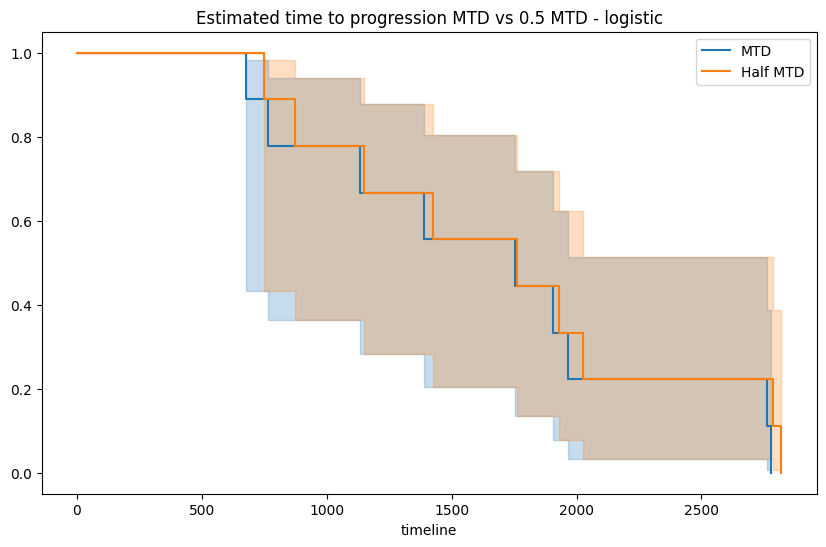

In [24]:
### survival plots for progression at 1.1*first data point 
Event1 = df_all_progressions["progression_event"]
Event2 = df_all_progressions["progression_event_half"]
Event3 = df_all_progressions["progression_event_02"]
Event4 = df_all_progressions["progression_event_0"]

kmf = KaplanMeierFitter()
# Set the figure size
plt.figure(figsize=(10, 6)) 

# plot for MTD progression
kmf.fit(df_all_progressions["progression"],Event1, label='MTD')
ax = kmf.plot_survival_function()
print("median time to progression MTD:", kmf.median_survival_time_)

# plot for 1/2 MTD progression
kmf.fit(df_all_progressions["progression half MTD"], Event2, label='Half MTD')
ax = kmf.plot_survival_function(ax=ax) 
ax.set_title("Estimated time to progression MTD vs 0.5 MTD - logistic")
print("median time to progression 1/2 MTD: ",kmf.median_survival_time_)

# plot for 0.2 MTD progression
#kmf.fit(df_all_progressions["progression 0.2 MTD"], Event3, label='0.2 MTD')
#ax = kmf.plot_survival_function(ax=ax)
#print("median time to progression 0.2 MTD: ",kmf.median_survival_time_)


median time to competitive release MTD: 65.10510510510511
median time to competitive release 1/2 dose:  130.21021021021022
median time to competitive release 0.2 dose:  328.23823823823824


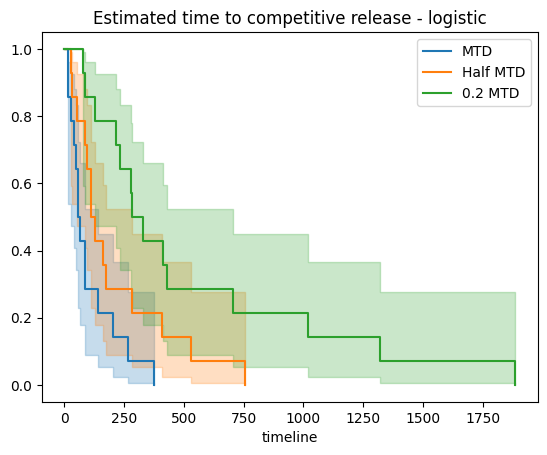

In [25]:
### survival plots for time to competitive release 
Event1 = df_all_progressions["cr_event"]
Event2 = df_all_progressions["cr_event_half"]
Event3 = df_all_progressions["cr_event_02_MTD"]

kmf = KaplanMeierFitter()

# plot for MTD progression
kmf.fit(df_all_progressions["competitive release"],Event1, label='MTD')
ax = kmf.plot_survival_function()
print("median time to competitive release MTD:", kmf.median_survival_time_)

# plot for 1/2 MTD progression
kmf.fit(df_all_progressions["competitive release half MTD"], Event2, label='Half MTD')
ax = kmf.plot_survival_function(ax=ax)
print("median time to competitive release 1/2 dose: ",kmf.median_survival_time_)

# plot for 0.2 MTD progression
kmf.fit(df_all_progressions["competitive release 0.2 MTD"], Event3, label='0.2 MTD')
ax = kmf.plot_survival_function(ax=ax)
ax.set_title('Estimated time to competitive release - logistic')

print("median time to competitive release 0.2 dose: ",kmf.median_survival_time_)

